In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack

# Importing the potential landscape file

In [2]:
x,y= np.loadtxt("potential_landscape.txt", delimiter = '\t', unpack=True)

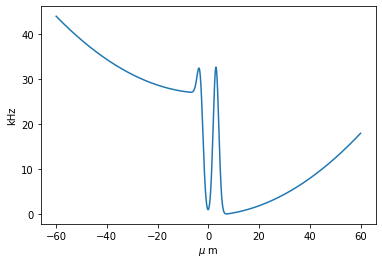

In [3]:
plt.plot(x,y)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

In [4]:
# Position where the gate well starts.
gate_well_start_index = -3.5
# Position where the gate well ends.
gate_well_end_index   = 3.5
    
def gate_well_potential(position,potential):
    
    # Extracts the gate well position.
    well_position = position[np.where((position > gate_well_start_index) & (position < gate_well_end_index))]
    # Extract the corresponding potential values for the gate well.
    well_potential = potential[np.where(position == well_position[0])[0][0]:np.where(position == well_position[-1])[0][0]+1]
    
    return [well_position,well_potential]

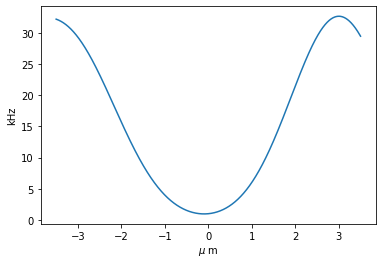

In [5]:
plt.plot(gate_well_potential(x,y)[0],gate_well_potential(x,y)[1])
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

In [6]:
# Constants.
PI    = np.pi
H_BAR = 1.0545*10**(-34) # m^2 kg/s

# Interpolation

In [7]:
r"""
def interpolate_array(x, new_length):
    original_length = len(x)
    if original_length >= new_length:
        return x[:new_length]  # Return a slice of the original array if it's already longer or equal to the desired length
    
    # Create a new array with the desired length
    interpolated_x = np.zeros(new_length)

    # Set the endpoints of the interpolated array
    interpolated_x[0] = x[0]
    interpolated_x[-1] = x[-1]

    # Determine the indices for interpolation
    indices = np.linspace(0, original_length - 1, num=new_length, endpoint=True, dtype=int)

    # Interpolate the values between endpoints
    interpolated_x[1:-1] = np.interp(indices[1:-1], range(original_length), x)

    return interpolated_x

def average_nearest_neighbors(x):
    length = len(x) // 2
    new_array = []

    for i in range(0, len(x), 2):
        average = (x[i] + x[i+1]) / 2
        new_array.append(average)

    return new_array""";

In [8]:
#position_average  = average_nearest_neighbors(position_average)
#potential_average = average_nearest_neighbors(potential_average)

In [9]:
#print("Length of potential array = 10 ^", np.log2(len(potential_average)))

In [10]:
# Finding the index of the minimum of potential.
#potential_min_index = np.argmin(potential_interp)
# Find the corresponding value of position at that index.
#position_min = position_interp[potential_min_index]
# Shift the minimum of the potential to zero position.
#position_interp = position_interp - position_min

In [11]:
#data = np.column_stack((position_interp, potential_interp))
#np.savetxt('potential_landscape_17.txt', data, delimiter='\t', fmt='%f')

In [12]:
# Plotting the interpolated gate well potential.
#plt.plot(position_interp,potential_interp)
#plt.xlabel(r"$\mu$ m")
#plt.ylabel(r"kHz")
#plt.show()

# Defining parameters and potentials

In [13]:
r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614

# For harmonic oscillator set g = 0.
g   = 0#(4*PI*H_BAR**2*a_s)/M


# Discretization of the momentum space.
xs = gate_well_potential(x,y)[0]
dx = (max(xs)-min(xs))/(len(xs))
dk = 2*PI/(max(xs)-min(xs))
dt = 1.e-8
N = len(xs)

# Space will be divided into N parts.
#N = len(gate_well_potential(x,y)[0])
#external_potential = gate_well_potential(x,y)[1]*(10**3)*(H_BAR)

# OMEGA is chosen such that V_harmonic(x_min) = min(gate_well_potential).
OMEGA = 4829.25
def V_external(xs):
    #OMEGA = 4829.25
    return 0.5*M*OMEGA**2*(xs*1.e-6)**2
    #return external_potential

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).
def Hamiltonian_x(x,psi):
    return V_external(x)+g*np.abs(psi)**2

In [14]:
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,-1)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

In [15]:
# A custom normalization function is needed to ensure correct normalization done using a sum instead of an integral.
def normalize(wavefunction):
    return np.linalg.norm(wavefunction)*np.sqrt(dx)

# Initial guess.
psi_initial = (1/np.sqrt(N))*np.ones(N)
psi_initial = psi_initial/normalize(psi_initial) 

# Sets the initial wavefunction as the guess.
psi_x    = psi_initial

# Wavefunction is transformed into momentum basis.
psi_k    = fftpack.fft(psi_x)

# Variable to store the normalization of the wavefunction.    
m = 20000
norm = 1.0
for i in range(m):
        
    # Normalized.
    # exp(-i H(k) * dt/(2*h_bar) * psi_k.
    psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k

    # Wavefunction is transformed into position basis.
    psi_x = fftpack.ifft(psi_k)
    # exp(-i H(x) * dt/h_bar) * psi_x.
    psi_x = np.exp(-(Hamiltonian_x(xs,psi_x) * dt)/H_BAR) * psi_x

    # Wavefunction is transformed into momentum basis.
    psi_k = fftpack.fft(psi_x)
    # exp(-i H(k) * dt/(2*h_bar) * psi_k.
    psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
        
    psi_x = fftpack.ifft(psi_k)
    
    norm *= normalize(psi_x)
    
    # Wavefunction is normalized.
    psi_x = psi_x/normalize(psi_x)
    psi_k = fftpack.fft(psi_x)        
    
    
psi_x = fftpack.ifft(psi_k)

print("Normalization of the final wavefunction = ", normalize(psi_x))

Normalization of the final wavefunction =  0.9999999999999999


In [26]:
(-(np.log(norm))*H_BAR/(m*dt))/(H_BAR*OMEGA)

1.1865107328205602

In [18]:
# The exact ground state of a quantum harmonic oscillator.
def psi_0(x):
    return (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*x**2)

# Plot

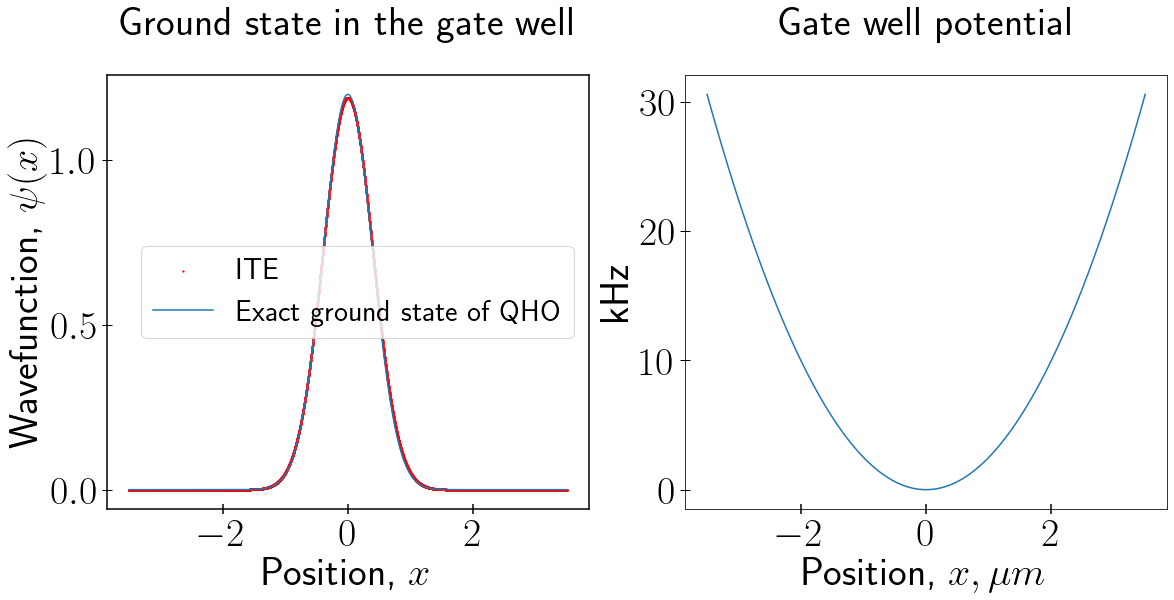

In [19]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
plt.scatter(xs,psi_x.real,s=1.5,color='red',label="ITE")
plt.plot(xs,psi_0(xs*1.e-6)/normalize(psi_0(xs*1.e-6)),label="Exact ground state of QHO")
plt.legend()
plt.title('Exact wavefunction')
plt.xlabel("Position, "+r"$x$",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
plt.title('Ground state in the gate well')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
    
plt.subplot(122)
# Plots the gate well potential.
#plt.plot(gate_well_potential(x,y)[0],gate_well_potential(x,y)[1],linewidth = 1.5)
#plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
#plt.ylabel(r"kHz")

# Plots the harmonic oscillator potential.
plt.plot(gate_well_potential(x,y)[0],V_external(xs)/(10**3*2*np.pi*H_BAR),linewidth = 1.5)
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Gate well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
f.set_figwidth(19)
f.set_figheight(8)
plt.show()